In [32]:
import sys
import time
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\Synth')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\Exceptions')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\DAQ')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\API')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\AGI335')
from Continuous_Acquisition import ACQUISITION_CONFIG
import Synthesizer
from logs.logging_config import LOGGING_CONFIG
from logging.config import dictConfig
import logging
import json
from Exceptions import replace_non_serializable
import DAQ
import niscope as ni
import numpy as np
import matplotlib.pyplot as plt
import AGI335

In [33]:
filepath = r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\API'

In [34]:
dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
logger.info('START EXECUTION')

12:22:10.019 - __main__ - <module> - INFO - START EXECUTION


In [35]:
try:
    cfg1 = json.dumps(replace_non_serializable(ACQUISITION_CONFIG))
    logger.info('Dumping acquisition configuration')
    with open(ACQUISITION_CONFIG['acq_conf']['path'] + 'config.json','w') as f:
        f.write(cfg1)
except Exception:
    logger.critical('Dumping acquisition configuration')
    raise SystemError("Could not dump acquisition configuration!")

12:22:10.372 - __main__ - <module> - INFO - Dumping acquisition configuration


In [36]:
try:
    daq = DAQ.DAQ()
    logger.info('DAQ class object correctly created')
except Exception:
    logger.critical('Could not crate DAQ class object')
    raise SyntaxError('Could not create DAQ class object')

12:22:10.987 - __main__ - <module> - INFO - DAQ class object correctly created


In [37]:
channels = {'I'			: 0, 
            'Q'			: 1,
            'trigger'	: 0}

In [38]:
devicename =  'PXI1Slot4'

In [39]:
try:
    daq.reset_with_def()
    daq.get_status
    logger.info('Resetting DAQ with defaults')
except Exception:
    logger.error('Could not reset DAQ with defaults')
    pass

12:22:12.242 - __main__ - <module> - ERROR - Could not reset DAQ with defaults


In [40]:
try:
    daq.acq_conf = ACQUISITION_CONFIG['acq_conf']
    logger.info('Inserting acquisition configuration from ACQUISITION_CONFIG dictionary')
except Exception:
    logger.warning('Coulkd not insert acquisition configuration')
    raise SystemError('Coulkd not insert acquisition configuration')

12:22:12.551 - __main__ - <module> - INFO - Inserting acquisition configuration from ACQUISITION_CONFIG dictionary


In [41]:
try:
    daq.horizontal_conf = ACQUISITION_CONFIG['horizontal']
    logger.info('Inserting hconf dic')
except Exception:
    logger.warning('Could not insert hconf dic')
    raise SystemError('Could not insert hconf dic')

12:22:13.012 - __main__ - <module> - INFO - Inserting hconf dic


In [42]:
try:
    daq.vertical_conf = ACQUISITION_CONFIG['vertical']
    logger.info('Inserting vconf dic')
except Exception:
    logger.warning('Could not insert vconf dic')
    raise SystemError('Could not insert vconf dic')

12:22:13.367 - __main__ - <module> - INFO - Inserting vconf dic


In [43]:
try:
    daq.chan_conf = ACQUISITION_CONFIG['chan_conf']
    logger.info('Inserting chan char dic')
except Exception:
    logger.warning('Could not insert chan char dic')
    raise SystemError('Could not insert chan char dic')

12:22:13.767 - __main__ - <module> - INFO - Inserting chan char dic


In [44]:
try:
    daq.trigger_dic = ACQUISITION_CONFIG['trigger']
    logger.info('Inserting trigger dic')
except Exception:
    logger.warning('Could not insert trigger dic')
    raise SystemError('Could not insert trigger dic')

12:22:14.040 - __main__ - <module> - INFO - Inserting trigger dic


In [45]:
pulser = AGI335.AGI335()

OBJECT INSTANCE CREATED


In [46]:
board = 'GPIB0::10::INSTR'
pulser.board = board

VALID BOARD


In [47]:
pulser.connect()
pulser.is_connected

True

In [48]:
pulser.function = 'SQU'
pulser.frequency = 1
pulser.offset = 0.5
pulser.voltage = 1

In [49]:
pulser.trigger_mode = 'IMM'

In [50]:
pulser.output = 'ON'

In [51]:
print(pulser.output)

ON


In [52]:
data = {'CH0': [],
        'CH1': []   
                }

In [53]:
daq._session = ni.Session(devicename)
daq.config_trigger()
with daq._session as session:
        logger.info('Configuring channels')
        daq.configure_channels()
        daq._session.initiate()
        waveforms = []
        for _ in range(10):
                time.sleep(1)
                pulser.execute_trigger()
                waveforms.extend(session.channels[0, 1].fetch())

12:22:17.479 - __main__ - <module> - INFO - Configuring channels


In [54]:
I = np.array(waveforms[0].samples.tolist())
Q = np.array(waveforms[1].samples.tolist())

In [55]:
S21 = np.abs(I*1j+Q)
P = np.unwrap(np.angle(I*1j+Q))

In [56]:
T = np.arange(0,len(I),1)

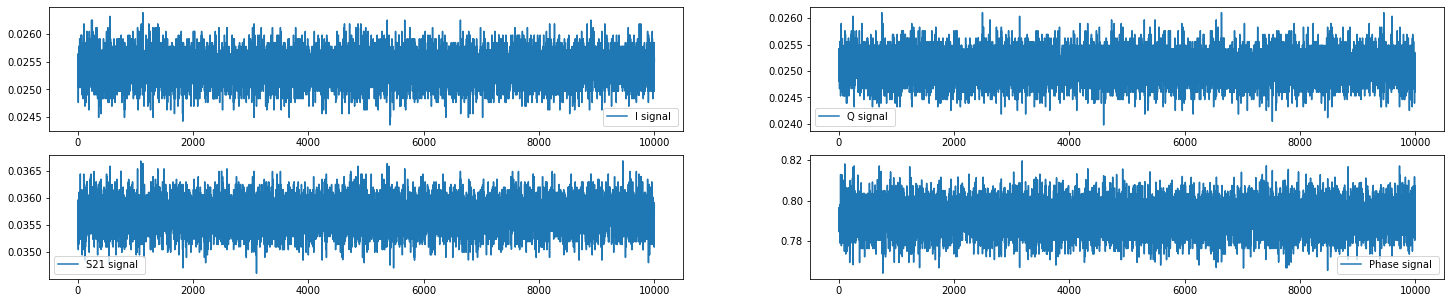

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(25,5))
axs[0][0].plot(T, I, label='I signal ')
axs[0][1].plot(T, Q, label='Q signal ')
axs[0][0].legend()
axs[0][1].legend()

axs[1][0].plot(T, S21, label='S21 signal ')
axs[1][1].plot(T, P, label='Phase signal ')
axs[1][0].legend()
axs[1][1].legend()